In [67]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import qutip as qt
import sympy as sym


%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [3]:
# Fundamental constants
h    = 6.626e-34
GHz  = 1e9
e0   = 1.602e-19
Φ_0  = h/(2*e0)

# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

Cc = 0.5

In [19]:
nmax_r = 4
nmax_f = 15

In [20]:
# Initialize loops
loop_qubit = sq.Loop(0.5)
loop1_qubit_C_qubit= sq.Loop(0.5)
loop2_qubit_C_qubit = sq.Loop(0.5)

# Circuit components
C_01, C_01_rc, C_02, C_02_rc, C_12, L_03, L_31, L_23, JJ_12 = [[] for _ in range(9)]
for loop in [loop_qubit, loop1_qubit_C_qubit, loop2_qubit_C_qubit]:
    C_01       .append(sq.Capacitor(C,          'fF'))
    C_01_rc    .append(sq.Capacitor(C+Cc,       'fF')) # With extra Cc for redout or coupling
    C_02       .append(sq.Capacitor(C,          'fF'))
    C_02_rc    .append(sq.Capacitor(C+Cc,       'fF')) # With extra Cc for redout or coupling
    C_12 .append(sq.Capacitor(CJ+Csh,  'fF'))
    L_03 .append(sq.Inductor(Lr,       'nH'))
    L_31 .append(sq.Inductor(Lq/2 - Δ, 'nH',  loops=[loop]))
    L_23 .append(sq.Inductor(Lq/2 + Δ, 'nH',  loops=[loop]))
    JJ_12.append(sq.Junction(EJ,       'GHz', loops=[loop]))
C_24 = sq.Capacitor(Cc, 'fF')


# Symmetric Cc coupling
That is, the inner nodes of the qubits are coupled with Cc, and the outer nodes of the qubits are coupled with Cc to their respective readout lines.
As a result, the renormalization induced by Cc ensures that the qubit and resonator modes are still the symmetric and atisymmetric combination of the fluxes of the upper nodes.

## Composing the circuit with fluxoniums and resonatrs

In [40]:
def hamiltonian_qubit_C_qubit(nmax_r, nmax_f, Cc, C = 15, CJ = 3, Csh= 15, Lq = 25, Lr = 10, Δ = 0.1, inverse='Numeric'):
    fF = 1e-15
    C_R = C/2
    C_C = Cc
    C_F = C/2 + Csh + CJ
    
    if inverse == 'Numeric':
        C_mat = np.array([[C_R + C_C/2, 0, -C_C / 2,        0],
                          [0, C_F + C_C/2,       0 , -C_C / 2],
                          [-C_C / 2,        0, C_R + C_C/2, 0],
                          [       0, -C_C / 2, 0, C_F + C_C/2]])
        # C_mat = np.array([[C_R + C_C/2, -C_C/4, -C_C / 2,        0],
        #                   [-C_C/4, C_F + C_C/2,       0 , -C_C / 2],
        #                   [-C_C / 2,        0, C_R + C_C/2, -C_C/4],
        #                   [       0, -C_C / 2, -C_C/4, C_F + C_C/2]])
        
        C_inv = np.linalg.inv(C_mat)
        C_R_tilde = C_inv[0,0]**-1
        C_F_tilde = C_inv[1,1]**-1
        C_RR      = C_inv[0,2]**-1
        C_FF      = C_inv[1,3]**-1
        
    elif inverse == 'Analytic':
        C_R_tilde = (C_C/2+C_R)/(C_R*(C_C+C_R))
        C_F_tilde = (C_C/2+C_F)/(C_F*(C_C+C_F))
        C_RR      = C_C/2/(C_R*(C_C+C_R))
        C_FF      = C_C/2/(C_F*(C_C+C_F))
        
    elif inverse == 'Approx':
        C_R_tilde = C_R
        C_F_tilde = C_F
        C_RR      = 2*C_R**2/C_C
        C_FF      = 2*C_F**2/C_C
    
    resonator = sq_ext.sq_resonator(C_R_eff=C_R_tilde, Lq = Lq, Lr = Lr, Δ = Δ, trunc_res =nmax_r)
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=C_F_tilde, Lq = Lq, Lr = Lr, Δ = Δ, trunc_flux=nmax_f)
    
    # H_qubit  = sq_ext.hamiltonian_qubit(fluxonium, resonator, Δ, C_int=C_inv[0,1]**-1)
    H_qubit  = sq_ext.hamiltonian_qubit(fluxonium, resonator, Δ)
    
    I_r       = qt.identity(nmax_r)
    I_f       = qt.identity(nmax_f)
    I_H_qubit = qt.identity(H_qubit .dims[0])
    
    q_r = qt.tensor(resonator.charge_op(0), I_f)
    q_f = qt.tensor(I_r, fluxonium.charge_op(0))
    
    H_0 =  qt.tensor(H_qubit, I_H_qubit) + qt.tensor(I_H_qubit, H_qubit) 
    H_coupling = 1/(C_RR*fF) * qt.tensor(q_r,q_r) + 1/(C_FF*fF) * qt.tensor(q_f,q_f)

    return H_0 + H_coupling


## Creating the full circuits with sqcircuits to check that the energies are the same
### Circuit elements

### Two qubits capacitively coupled

In [22]:
elements_qubit_C_qubit = { 
    # qubit 1, nodes [0, 1, 2, 3]
    (0, 3): [L_03[1]],
    (0, 1): [C_01[1]],
    (0, 2): [C_02[1]],
    (3, 1): [L_31[1]],
    (1, 2): [C_12[1], JJ_12[1]],
    (2, 3): [L_23[1]],
    # qubit 2, nodes [0, 4, 5, 6]
    (0, 6): [L_03[2]],
    (0, 4): [C_01[2]],
    (0, 5): [C_02[2]],
    (6, 4): [L_31[2]],
    (4, 5): [C_12[2], JJ_12[2]],
    (5, 6): [L_23[2]],
    # capacitive coupling
    (2, 4): [C_24],
    (1, 5): [C_24]
}

qubit_C_qubit = sq.Circuit(elements_qubit_C_qubit)
qubit_C_qubit.set_trunc_nums([nmax_r, nmax_r, nmax_f, nmax_f])
qubit_C_qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Couplig vs capacitance

In [76]:
# Cc_values = np.concatenate((np.array([0]), np.geomspace(1e-3, 1e2, 15)))
Cc_values = np.linspace(0.1, 100, 30)
Lq=10
EJ=25

In [79]:
P = np.zeros([len(Cc_values), 4, 4], dtype='complex')
for i, Cc in enumerate(Cc_values):
    # _, ψ_0 = sq_ext.hamiltonian_qubit_C_qubit(nmax_r=3, nmax_f=10,Lq=Lq, EJ=EJ, Cc=Cc, return_Ψ_nonint=True)
    # H=sq_ext.sq_qubit_C_qubit(nmax_r=3, nmax_f=10,Lq=Lq, EJ=EJ, Cc=Cc).hamiltonian().permute([2,0,3,1])
    # H_eff  = sq_ext.H_eff_SWT(ψ_0, H, 4, out='GHz', real=False, remove_ground = True)
    
    H, ψ_0 = sq_ext.hamiltonian_qubit_C_qubit(nmax_r=5, nmax_f=15, Cc=Cc, return_Ψ_nonint=True)
    # H, ψ_0 = sq_ext.hamiltonian_fluxonium_C_fluxonium( nmax_f=25, Cc=Cc, Lq=10, EJ=25, return_Ψ_nonint=True)
    H_eff  = sq_ext.H_eff_SWT(ψ_0, H, 4, out='GHz', real=False, remove_ground = True)
    P[i]   = sq_ext.decomposition_in_pauli_4x4(H_eff, print=False)

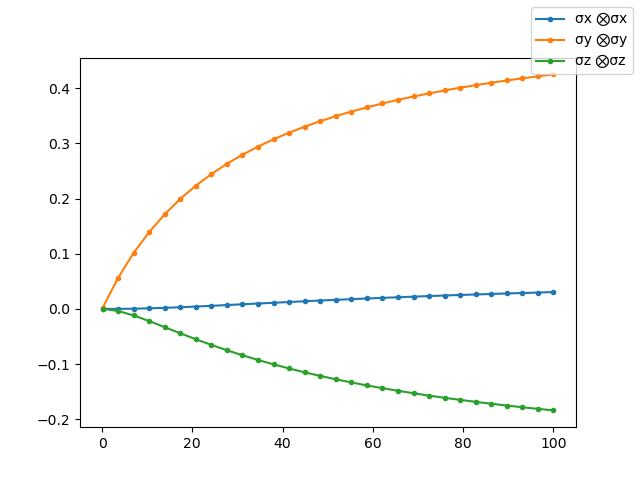

In [80]:
labels = ['I', 'σx', 'σy', 'σz']  
 
fig, ax = plt.subplots()
for i in range(1,4):
    for j in range(1,4):
        if np.any(np.abs(P[:,i,j])>1e-10):
            ax.plot(Cc_values, P[:,i,j],'.-' , label = labels[i] + ' \U00002A02' + labels[j])
            # ax.plot(Cc_values, np.abs(P[:,i,j]),'.-' , label = labels[i] + ' \U00002A02' + labels[j])
fig.legend()
fig.show()

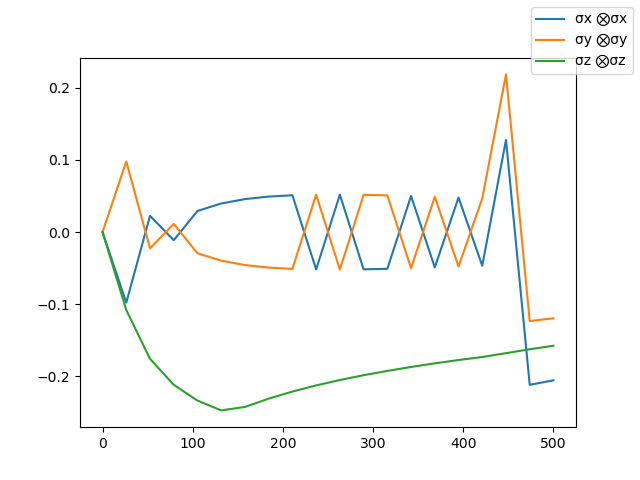

In [70]:
labels = ['I', 'σx', 'σy', 'σz']   

fig, ax = plt.subplots()
for i in range(1,4):
    for j in range(1,4):
        if np.any(np.abs(P[:,i,j])>1e-10):
            ax.plot(Cc_values, P[:,i,j], label = labels[i] + ' \U00002A02' + labels[j] )
fig.legend()
fig.show()

/home/gabriel/anaconda3/envs/tunable-cc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


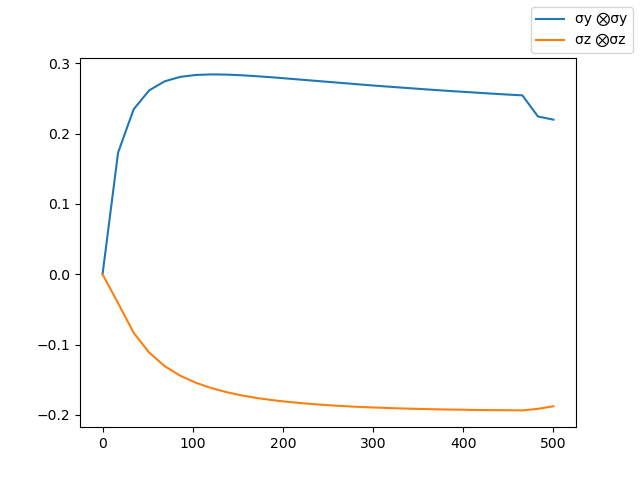

In [53]:
labels = ['I', 'σx', 'σy', 'σz']  # useful to print the result.
fig, ax = plt.subplots()
ax.plot(Cc_values, P[:,2,2], label = labels[2] + ' \U00002A02' + labels[2] )
ax.plot(Cc_values, P[:,3,3], label = labels[3] + ' \U00002A02' + labels[3] )
fig.legend()
fig.show()

In [41]:
P[-1]

array([[ 0.7685+0.j,  0.    +0.j,  0.    +0.j, -0.3079+0.j],
       [ 0.    +0.j,  0.0279-0.j, -0.    -0.j,  0.    +0.j],
       [ 0.    +0.j,  0.    -0.j,  0.283 -0.j,  0.    +0.j],
       [-0.3079-0.j,  0.    +0.j,  0.    +0.j, -0.1527-0.j]])